Auxiliary functions

In [10]:
from aux import extrapolate_in_time, interpolate_in_space, grad

Advectee and advector initialization

In [11]:
from MPyDATA import ScalarField, VectorField, PeriodicBoundaryCondition
from MPyDATA.options import Options
import numpy as np
options = Options(n_iters=2, infinite_gauge=True, flux_corrected_transport=True)

nx, ny = 10, 10
dx = 1.
dy = 1.
dt = 0.05

#initial state of liquid
initial_m_value = 0.2
h_initial = np.full((ny, nx), initial_m_value)


#simple modification of liquid
h_initial[4:8, 5:8] = np.array([[0.8 - (0.09 * i*j)  for i in range(3)] for j in range(4)])

h_old = np.array(h_initial)
h_new = np.array(h_initial)

uh_new_x = np.zeros((ny, nx))
uh_old_x = np.zeros((ny, nx))
uh_new_y = np.zeros((ny, nx))
uh_old_y = np.zeros((ny, nx))

u_initial_x = np.zeros((ny, nx + 1))
u_initial_y = np.zeros((ny + 1, nx))

u_old =  np.array(u_initial_y), np.array(u_initial_x)
u_new =  np.array(u_initial_y), np.array(u_initial_x)

rhs_old_x = np.array(h_initial)
rhs_old_y = np.array(h_initial)
rhs_new_x = np.array(h_initial)
rhs_new_y = np.array(h_initial)

halo = options.n_halo

advectee = ScalarField(
    data = h_new,
    halo=halo, 
    boundary_conditions=(PeriodicBoundaryCondition(), PeriodicBoundaryCondition())
)

advector = VectorField(
    data = (u_initial_y, u_initial_x),
    halo=halo,
    boundary_conditions=(PeriodicBoundaryCondition(), PeriodicBoundaryCondition())   
)

print('h_new', h_new,'\n')
print('u_initial_x', u_initial_y,'\n')
print('grad_x', grad(h_new, dx=dx, dy=dy)[1],'\n')

h_new [[0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2  0.8  0.8  0.8  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2  0.8  0.71 0.62 0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2  0.8  0.62 0.44 0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2  0.8  0.53 0.26 0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2 ]
 [0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2 ]] 

u_initial_x [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] 

grad_x [[ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 

MPyDATA wrapper

In [12]:
from mpdata import mpdata_wrapper
MPDATA = mpdata_wrapper(advector, advectee, (ny, nx)) 

Initial state

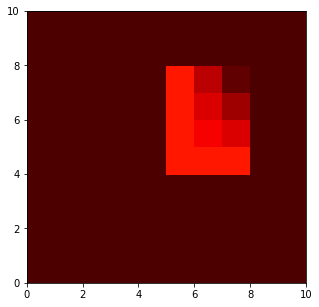

In [13]:
import matplotlib.pyplot as plt

image_width = image_height = 5
plt.figure(figsize=(image_width, image_height))
plt.pcolor(h_new, cmap='hot', vmin=0, vmax=2)
plt.show()

Main loop

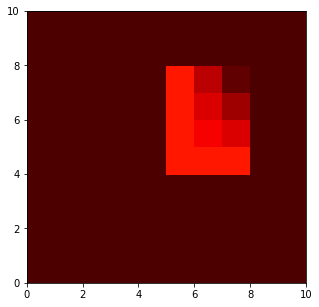

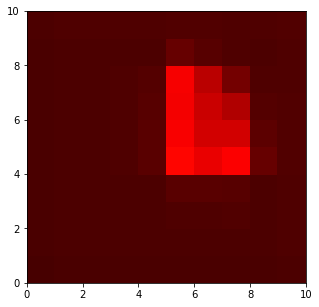

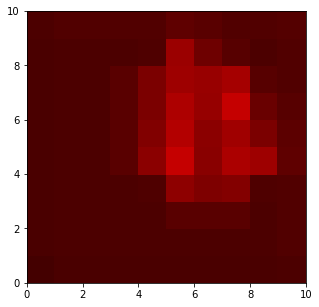

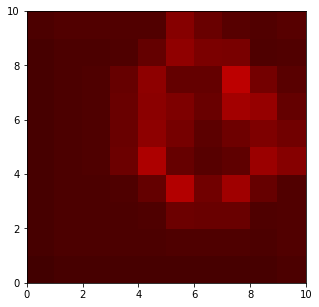

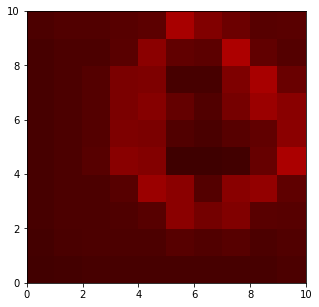

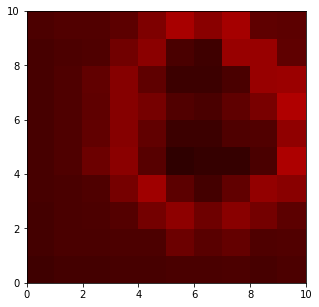

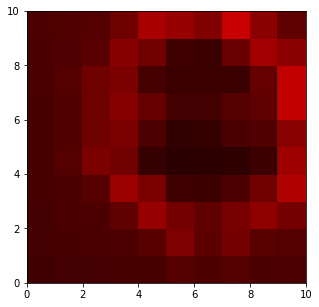

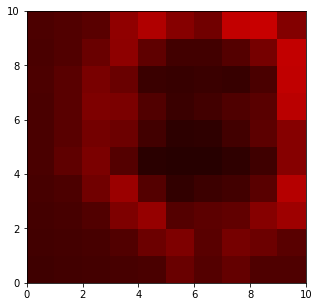

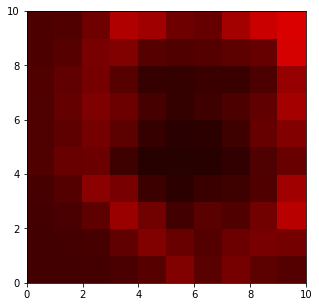

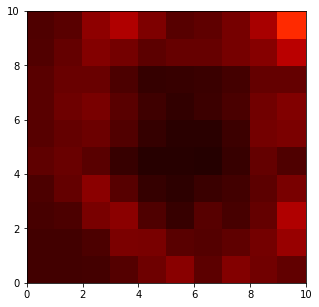

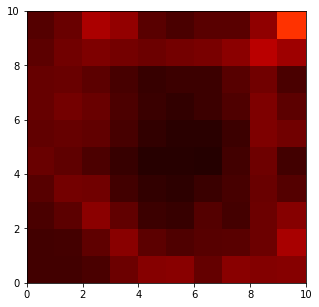

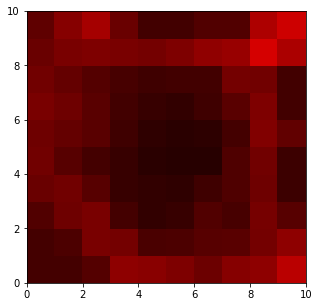

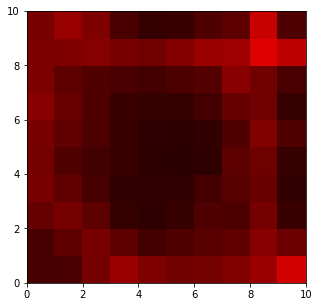

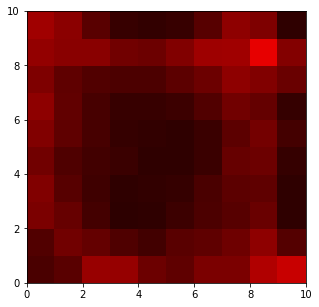

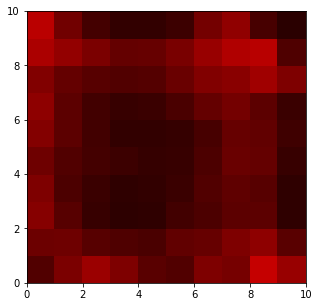

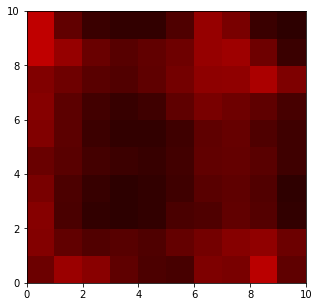

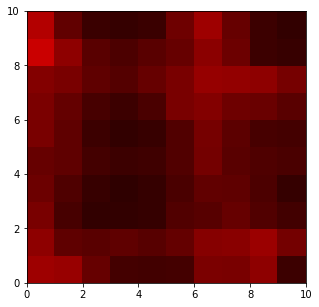

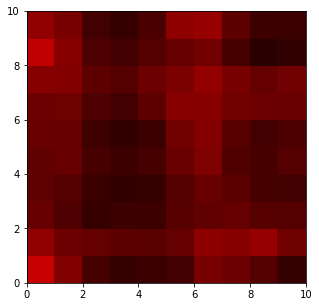

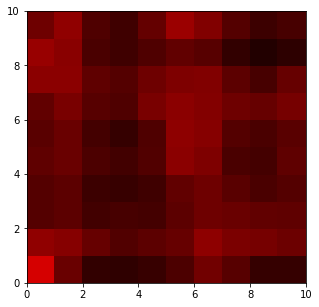

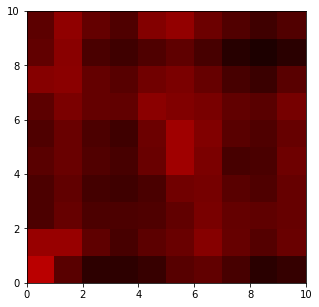

In [14]:
g = 9.8 # m/s^2


for i in range(20):
    u_mid_x = extrapolate_in_time(interpolate_in_space(uh_new_x, h_new, axis='x'), interpolate_in_space(uh_old_x, h_old, axis='x'))
    u_mid_y = extrapolate_in_time(interpolate_in_space(uh_new_y, h_new, axis='y'), interpolate_in_space(uh_old_y, h_old, axis='y'))
    u_mid = (u_mid_y, u_mid_x)

    #RHS = 0, mass conservation
    h_new[:] = MPDATA(u_mid, h_old)
    grad_y, grad_x = grad(h_new, dx=dx, dy=dy)
    
    #without Coriolis parameter
    rhs_new_x = -g * h_new * grad_x  + ((1./h_new)*(grad_y - grad_x) * uh_new_y)
    rhs_new_y = -g * h_new * grad_y  - ((1./h_new)*(grad_y - grad_x) * uh_new_x)
    
    #momentum conservation
    uh_new_x[:] = MPDATA(u_mid, uh_old_x + .5 * dt * rhs_old_x) + .5 * dt * rhs_new_x
    uh_new_y[:] = MPDATA(u_mid, uh_old_y + .5 * dt * rhs_old_y) + .5 * dt * rhs_new_y
    
    #plot figure
    plt.figure(figsize=(image_width,image_height))
    plt.pcolor(h_new, cmap='hot', vmin=0, vmax=2)
    plt.show()
   

    # replace variables
    h_old, h_new = h_new, h_old
    u_old, u_new = u_new, u_old
    
    rhs_old_x, rhs_new_x = rhs_new_x, rhs_old_x
    rhs_old_y, rhs_new_y = rhs_new_y, rhs_old_y
    
    uh_old_x, uh_new_x = uh_new_x, uh_old_x
    uh_old_y, uh_new_y = uh_new_y, uh_old_y

    